In [1]:
import os

import numpy as np
import matplotlib.pyplot as plt

import pandas as pd
import geopandas as gpd

import xarray as xr

from shapely.wkt import loads
from shapely.geometry import Polygon
from shapely.geometry import Point

import rasterio
import rasterio.sample

from functools import partial
from scipy.spatial.distance import cdist

In [2]:
parquet_files = {'marine_protected_areas': ('../data/PR100/Habitat/marine_protected_areas.parquet',
  'EPSG:32161',
  'centroid'),
 'land_nationwide_hapc': ('../data/PR100/Habitat/land_nationwide_hapc.parquet',
  'EPSG:32161',
  'centroid'),
 'artificial_reefs': ('../data/PR100/Habitat/artificial_reefs.parquet',
  'EPSG:32161',
  'irrelevant'),
 'nationwide_hapc': ('../data/PR100/Habitat/nationwide_hapc.parquet',
  'EPSG:32161',
  'irrelevant'),
 'areas_protegidas_agencia': ('../data/PR100/Habitat/areas_protegidas_agencia.parquet',
  'EPSG:32161',
  'centroid'),
 'noaa_charted_submarine_cables_30m_buffer': ('../data/PR100/Infrastructure/noaa_charted_submarine_cables_30m_buffer.parquet',
  'EPSG:32161',
  'irrelevant'),
 'setbacks_xmission': ('../data/PR100/Infrastructure/setbacks_xmission.parquet',
  'EPSG:32161',
  'lines'),
 'submarine_cable_30m_buffer': ('../data/PR100/Infrastructure/submarine_cable_30m_buffer.parquet',
  'EPSG:32161',
  'irrelevant'),
 'pipeline_areas': ('../data/PR100/Infrastructure/pipeline_areas.parquet',
  'EPSG:32161',
  'irrelevant'),
 'setbacks_roads': ('../data/PR100/Infrastructure/setbacks_roads.parquet',
  'EPSG:4326',
  'density'),
 'setbacks_runway': ('../data/PR100/Infrastructure/setbacks_runway.parquet',
  'EPSG:4326',
  'centroid'),
 'setbacks_airport': ('../data/PR100/Infrastructure/setbacks_airport.parquet',
  'EPSG:4326',
  'points'),
 'setbacks_buildings': ('../data/PR100/Infrastructure/setbacks_buildings.parquet',
  'EPSG:4326',
  'density'),
 'federal_and_state_waters': ('../data/PR100/Boundaries/federal_and_state_waters.parquet',
  'EPSG:32161',
  'centroid'),
 'coastal_zone_mgmt_act_boundary': ('../data/PR100/Boundaries/coastal_zone_mgmt_act_boundary.parquet',
  'EPSG:32161',
  'centroid'),
 'land_protected_areas': ('../data/PR100/Boundaries/land_protected_areas.parquet',
  'EPSG:32161',
  'centroid'),
 'water_bodies': ('../data/PR100/Topography/water_bodies.parquet',
  'EPSG:4326',
  'centroid'),
 'wrecks_and_obstructions': ('../data/PR100/Hazards/wrecks_and_obstructions.parquet',
  'EPSG:4326',
  'points'),
 'ocean_disposal_sites': ('../data/PR100/Hazards/ocean_disposal_sites.parquet',
  'EPSG:32161',
  'centroid'),
 'tropical_cyclone_storm_segments': ('../data/PR100/Hazards/tropical_cyclone_storm_segments.parquet',
  'EPSG:32161',
  'lines'),
 'tropical_cyclone_wind_exposure': ('../data/PR100/Hazards/tropical_cyclone_wind_exposure.parquet',
  'EPSG:32161',
  'wind_exposure'),
 'unexploded_ordinance_areas_fuds': ('../data/PR100/Hazards/unexploded_ordinance_areas_fuds.parquet',
  'EPSG:32161',
  'irrelevant'),
 'danger_zones_and_restricted_areas': ('../data/PR100/Hazards/danger_zones_and_restricted_areas.parquet',
  'EPSG:32161',
  'centroid'),
 'unexploded_ordinance_areas': ('../data/PR100/Hazards/unexploded_ordinance_areas.parquet',
  'EPSG:4326',
  'centroid')}

In [3]:
tif_files = ['../data/wind_atlas/PRI_wind-speed_100m.tif',
 '../data/solar_atlas/GHI.tif',
 '../data/PR100/Topography/slope.tif',
 '../data/PR100/Topography/elevation.tif']

In [4]:
binary_mask_columns = ['marine_protected_areas', 'land_nationwide_hapc',
       'areas_protegidas_agencia', 'setbacks_xmission',
       'setbacks_runway', 'setbacks_airport',
       'federal_and_state_waters', 'coastal_zone_mgmt_act_boundary',
       'land_protected_areas', 'water_bodies', 'wrecks_and_obstructions',
       'ocean_disposal_sites', 'danger_zones_and_restricted_areas',
       'unexploded_ordinance_areas']

In [5]:
def find_parquet_files(directory):
    """
    Find all Parquet files within a directory and its subdirectories.

    :param directory: The base directory to search.
    :return: A list of paths to Parquet files.

    Note: This function isn't used in this notebook, because the file list
    has already been generated and enriched (see 'parquet_files' dict above)
    """
    parquet_files = []
    for root, dirs, files in os.walk(directory):
        for file in files:
            if file.endswith('.parquet'):
                parquet_files.append(os.path.join(root, file))
    return parquet_files

In [6]:
def find_tif_files(directory):
    """
    Find all TIF files within a directory and its subdirectories.

    :param directory: The base directory to search.
    :return: A list of paths to TIF files.

    Note: This function isn't used in this notebook, because the file list
    has already been generated (see 'tif_files' dict above)
    """
    tif_files = []
    for root, dirs, files in os.walk(directory):
        for file in files:
            if file.endswith('.tif'):
                tif_files.append(os.path.join(root, file))
    return tif_files

In [7]:
def get_gdf(parquet_file, crs, grid):
    df = pd.read_parquet(parquet_file)
    df['geometry'] = df['geometry'].apply(loads)
    gdf = gpd.GeoDataFrame(df, geometry='geometry')
    gdf.set_crs(crs, inplace=True)
    gdf.to_crs(grid.crs, inplace=True)
    return gdf

In [8]:
def create_grid(x_start, x_end, y_start, y_end, square_size):
    grid = []
    for x in np.arange(x_start, x_end, square_size):
        for y in np.arange(y_start, y_end, square_size):
            # Define the square's coordinates
            square = Polygon([(x, y), (x + square_size, y), (x + square_size, y + square_size), (x, y + square_size)])
            grid.append(square)
    return gpd.GeoDataFrame({'geometry': grid}, crs="EPSG:32161")

In [9]:
def calculate_cyclone_failure_percentage(df):
    probability_of_hurricane_occuring = df['occurrence64ktMajorHurricanes'] / 117
    probability_of_failure_due_to_hurricane = 0.5
    average_life_span = 25
    df['turbine_cyclone_failure_percentage'] = probability_of_hurricane_occuring * probability_of_failure_due_to_hurricane * average_life_span / 2
    return df

In [10]:
def rasterize_cyclone_failure_risk(grid_gdf, cyclone_data_gdf):
    # Ensure both dataframes are in the same CRS
    cyclone_data_gdf = cyclone_data_gdf.to_crs(grid_gdf.crs)

    # Spatial join - to associate cyclone data with each grid cell
    joined_gdf = gpd.sjoin(grid_gdf, cyclone_data_gdf, how='left', predicate='intersects')

    # Apply the failure cost calculation to each row
    joined_gdf = calculate_cyclone_failure_percentage(joined_gdf)

    # Group by grid cell index and average the scores within each cell
    aggregated_scores = joined_gdf.groupby(joined_gdf.index)['turbine_cyclone_failure_percentage'].mean()

    return aggregated_scores.reindex(grid_gdf.index, fill_value=0)

In [11]:
def rasterize(grid, data, type):
    joined_gdf = gpd.sjoin(grid, data[['geometry']], how='right', predicate='intersects')
    count = joined_gdf.groupby('index_left').size().reindex(grid.index, fill_value=0)
    if type == 'density':
        return count
    else:
        return count > 0

In [12]:
def process_parquet_file(file_path, crs, type, handle, grid):
    gdf = get_gdf(file_path, crs, grid)
    if type == 'irrelevant':
        pass
    elif type == 'wind_exposure':
        grid[handle] = rasterize_cyclone_failure_risk(grid, gdf)
    else:
        grid[handle] = rasterize(grid, gdf, type)

In [13]:
def process_parquet_files(files, grid):
    for handle, file_data in files.items():
        file_path = file_data[0]
        crs = file_data[1]
        type = file_data[2]
        print(f'Processing file: {file_path}')
        process_parquet_file(file_path, crs, type, handle, grid)

In [14]:
def process_tif_file(file_path, grid, coords):
    handle = file_path.split('/')[-1].split('.')[0]
    # Open the raster and sample values at each coordinate
    with rasterio.open(file_path) as src:
        if grid.crs != src.crs:
            centroids = grid.geometry.centroid.to_crs(src.crs)
            coords = [(x,y) for x, y in zip(centroids.geometry.x, centroids.geometry.y)]

        # Sample the raster at each centroid location
        values = [x[0] for x in rasterio.sample.sample_gen(src, coords)]
    
    # Assign the values to the grid dataframe
    grid[handle] = values

In [15]:
def process_hourly_file(grid, hourly):
    # Ensure both DataFrames are in the same CRS
    if grid.crs != hourly.crs:
        hourly_wind = hourly.to_crs(grid.crs)

    # Iterate over the columns in hourly and assign values to grid
    for column in hourly.columns:
        joined = gpd.sjoin_nearest(grid, hourly[[column, 'geometry']], how='left')
        grid[column] = joined[column]

    return grid

In [16]:
def process_tif_files(files, grid):
    # Compute centroids
    centroids = grid.geometry.centroid
    # Create an array of coordinates in (x, y) format
    coords = [(x,y) for x, y in zip(centroids.geometry.x, centroids.geometry.y)]

    for file_path in tif_files:
        print(f'Processing file: {file_path}')
        process_tif_file(file_path, grid, coords)

In [17]:
def plot_columns(gdf, columns=[]):
    if len(columns) == 0:
        columns = gdf.columns
    for column in columns:
        if column in ['geometry', 'centroid']:
            continue
        fig, ax = plt.subplots(1, 1, figsize=(12, 8))
        environment_gdf.plot(column=column, ax=ax, legend=True)
        plt.title(column)
        plt.show()

In [18]:
environment_gdf = create_grid(100000, 300000, 200000, 300000, 500)

In [19]:
process_parquet_files(parquet_files, environment_gdf)

Processing file: ../data/PR100/Habitat/marine_protected_areas.parquet
Processing file: ../data/PR100/Habitat/land_nationwide_hapc.parquet
Processing file: ../data/PR100/Habitat/artificial_reefs.parquet
Processing file: ../data/PR100/Habitat/nationwide_hapc.parquet
Processing file: ../data/PR100/Habitat/areas_protegidas_agencia.parquet
Processing file: ../data/PR100/Infrastructure/noaa_charted_submarine_cables_30m_buffer.parquet
Processing file: ../data/PR100/Infrastructure/setbacks_xmission.parquet
Processing file: ../data/PR100/Infrastructure/submarine_cable_30m_buffer.parquet
Processing file: ../data/PR100/Infrastructure/pipeline_areas.parquet
Processing file: ../data/PR100/Infrastructure/setbacks_roads.parquet
Processing file: ../data/PR100/Infrastructure/setbacks_runway.parquet
Processing file: ../data/PR100/Infrastructure/setbacks_airport.parquet
Processing file: ../data/PR100/Infrastructure/setbacks_buildings.parquet
Processing file: ../data/PR100/Boundaries/federal_and_state_wat

In [20]:
process_tif_files(tif_files, environment_gdf)

Processing file: ../data/wind_atlas/PRI_wind-speed_100m.tif
Processing file: ../data/solar_atlas/GHI.tif
Processing file: ../data/PR100/Topography/slope.tif
Processing file: ../data/PR100/Topography/elevation.tif


In [21]:
environment_gdf['masked'] = environment_gdf[binary_mask_columns].any(axis=1)

In [22]:
environment_gdf['water'] = environment_gdf[['federal_and_state_waters', 'water_bodies']].any(axis=1)

In [23]:
environment_gdf['centroid'] = environment_gdf.centroid

In [24]:
environment_gdf['occupied_solar'] = False
environment_gdf['occupied_wind'] = False

## Calculating per-cell energy demand

In [25]:
# Load the demand profile data
demand_df = pd.read_csv('../data/generation_and_demand/demand_profile.csv')

# Convert the DataFrame to a dictionary with 'hour' as keys and 'demand_MW' as values
demand_dict = dict(zip(demand_df['local_hour'], demand_df['demand_MW']))

# Calculate total building density
total_building_density = environment_gdf['setbacks_buildings'].sum()

# Loop through each hour in the demand dictionary and create a corresponding demand column
for hour, hour_demand in demand_dict.items():
    # Create a new column for this hour's demand
    environment_gdf[f'demand_{hour}'] = hour_demand * environment_gdf['setbacks_buildings'] / total_building_density

## Calculating dist to nearest transmission line

In [26]:
def nearest_transmission_distance(row, gdf):
    if row['setbacks_xmission'] or row['masked']:
        return 0
    else:
        # Calculate distances to all cells where setbacks_xmission is True
        distances = gdf[gdf['setbacks_xmission']]['geometry'].distance(row['geometry'])
        # Return the minimum distance
        return distances.min()

In [27]:
environment_gdf['distance_to_transmission_line'] = environment_gdf.apply(nearest_transmission_distance, gdf=environment_gdf, axis=1)

# Incorporating ERA5 Wind Speed Data

This is data I saved off from an ERA5/Copernicus dataset. I grouped 365 days by lat-lon-hour_of_day to get diurnal wind curves. 
These are available at 25km resolution, so pretty low res. For that reason, we don't use the actual 100m wind speed values. 
Instead, we calculate a noramalized hourly coefficien, which we multiply with 100m wind speed data from the Global Wind Atlas to 
get an estimate of diurnal wind speed variability using the higher resolution GWA data. 

In [28]:
# Total wind speed is derived in this dataset. This cell extracts it and shows what the data looks like. 
ds = xr.open_dataset("../data/generation_and_demand/2019_wind_speeds.nc")
total_wind_speed_array = ds.total_wind_speed
total_wind_speed_np = np.array(total_wind_speed_array)
print(total_wind_speed_np.shape)

(24, 7, 21)


In [29]:
# Loop through lat, lon, and hr to get normalized values

hrs = np.array(ds.coords['hour'])
lats = np.array(ds.coords['latitude'])
lons = np.array(ds.coords['longitude'])

lists = []
for lat_idx in range(0, ds.coords['latitude'].shape[0]):
    for lon_idx in range(0, ds.coords['longitude'].shape[0]):
        hour_wind_speeds = {}
    
        this_point_wind_speeds = total_wind_speed_np[:, lat_idx, lon_idx]
        this_normalized_wind_speeds = this_point_wind_speeds/np.mean(this_point_wind_speeds)
        
        for hr_idx in range(0, ds.coords['hour'].shape[0]):
            this_point = Point(lons[lon_idx], lats[lat_idx])
    
            this_hour = hrs[hr_idx]

            if this_hour == 0:
                this_hour = 24

            hour_wind_speeds[f'normalized_wind_speed_hour_{this_hour}'] = this_normalized_wind_speeds[hr_idx]

        lists.append({'latitude': lats[lat_idx], 'longitude': lons[lon_idx], 'geometry': this_point, **hour_wind_speeds})

diurnal_wind_speed_gdf = gpd.GeoDataFrame(lists)
diurnal_wind_speed_gdf.set_crs(epsg=4326, inplace=True)
diurnal_wind_speed_gdf.to_crs(epsg=32161, inplace=True)

In [30]:
environment_gdf = gpd.sjoin_nearest(environment_gdf, diurnal_wind_speed_gdf.drop(columns=['latitude', 'longitude']), how='left').drop(columns=["index_right"])

normalized_wind_speed_columns = [col for col in environment_gdf.columns.values if 'normalized_wind_speed_hour_' in col]
raw_wind_speed_columns = [col.lstrip('normalized_') for col in normalized_wind_speed_columns]

environment_gdf[raw_wind_speed_columns] = environment_gdf[normalized_wind_speed_columns].mul(environment_gdf['PRI_wind-speed_100m'], axis=0)
environment_gdf = environment_gdf.drop(columns=normalized_wind_speed_columns)

In [31]:
# https://en.wind-turbine-models.com/turbines/1345-vestas-v126-3.0

power_curve = pd.read_csv('../data/generation_and_demand/V126_3MW_power_curve.csv')
power_curve = {row['wind_speed']: row['power_kW'] for idx, row in power_curve.iterrows()}

power_curve_key = np.array(list(power_curve.keys()))
power_curve_val = np.array(list(power_curve.values()))

power_curve_function = partial(np.interp, xp=power_curve_key, fp=power_curve_val, left=0, right=0)

power_columns = [col.replace('wind_speed_', 'wind_power_kW_') for col in raw_wind_speed_columns]

environment_gdf[power_columns] = environment_gdf[raw_wind_speed_columns].map(power_curve_function)
environment_gdf = environment_gdf.drop(columns=raw_wind_speed_columns)
environment_gdf[power_columns].describe()

,wind_power_kW_hour_24,wind_power_kW_hour_1,wind_power_kW_hour_2,wind_power_kW_hour_3,wind_power_kW_hour_4,wind_power_kW_hour_5,wind_power_kW_hour_6,wind_power_kW_hour_7,wind_power_kW_hour_8,wind_power_kW_hour_9,...,wind_power_kW_hour_14,wind_power_kW_hour_15,wind_power_kW_hour_16,wind_power_kW_hour_17,wind_power_kW_hour_18,wind_power_kW_hour_19,wind_power_kW_hour_20,wind_power_kW_hour_21,wind_power_kW_hour_22,wind_power_kW_hour_23
count,80000.000000,80000.000000,80000.000000,80000.000000,80000.000000,80000.000000,80000.000000,80000.000000,80000.000000,80000.000000,...,80000.000000,80000.000000,80000.000000,80000.000000,80000.000000,80000.000000,80000.000000,80000.000000,80000.000000,80000.000000
mean,896.765698,951.216660,998.051965,1031.183152,1040.361293,1026.041629,1005.934774,991.615356,989.456263,1009.835681,...,994.908400,1022.124154,1026.716070,1024.062218,1030.228408,1030.793541,1021.448508,1013.132985,844.155398,861.216914
std,519.577338,522.924645,529.233807,531.699017,525.716525,513.468361,501.782834,491.061170,487.969717,497.407475,...,433.724028,454.562118,494.884540,542.600625,587.890482,617.650697,626.474828,620.671176,539.197588,525.649918
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,410.381327,457.747616,498.172497,527.355714,540.297759,538.958433,531.168941,527.097862,528.977217,543.279655,...,590.772122,607.078214,575.008116,514.685175,490.927928,475.146700,462.255028,449.940907,344.306300,378.975567
50%,879.656710,971.171400,1057.620970,1125.858575,1160.924316,1160.929190,1152.343363,1143.568549,1144.060370,1164.131815,...,1160.284637,1159.982050,1091.018597,1030.467621,1046.321286,1027.166474,974.935889,951.203139,784.417964,821.299412
75%,1348.978822,1398.438525,1408.579424,1429.928996,1438.973187,1411.928468,1387.513838,1376.924382,1370.803312,1392.039945,...,1339.170846,1385.880073,1448.828281,1447.477594,1479.069665,1466.019070,1446.286271,1574.827918,1314.521739,1287.134727
max,2790.630898,2871.043205,2916.640751,2931.522732,2937.255087,2930.219603,2911.088982,2904.491287,2909.031845,2923.856077,...,2997.449097,2999.380936,2999.370096,2999.144680,2994.979401,2986.535549,2970.638800,2946.058121,2639.082449,2739.296558


# Calculating Hourly Solar Data

In [32]:
hourly_solar_gdf = gpd.read_parquet('../data/generation_and_demand/pr_hourly_ghi_normalized.parquet')

In [33]:
hourly_solar_gdf.to_crs(environment_gdf.crs, inplace=True)

joined_gdf = gpd.sjoin_nearest(environment_gdf, hourly_solar_gdf, how='left')

# GHI is given in terms of daily totals of kWh/m^2
area = 500**2
ground_coverage_factor = 0.5
solar_panel_efficiency = 0.2
inverter_efficiency = 0.95
hours_in_a_day = 24
GHI_to_kW = area * ground_coverage_factor * solar_panel_efficiency * inverter_efficiency / hours_in_a_day

# Multiplying the GHI with hourly factors
# Creating new columns for each hour
for hour in range(1, 25):
    hour_str = str(hour)
    environment_gdf[f'solar_power_kW_hour_{hour_str}'] = (joined_gdf['GHI'] * joined_gdf[hour_str] * GHI_to_kW).fillna(0)

In [34]:
environment_gdf.to_parquet('../data/processed/environment_gdf.parquet')

# Calculating Installation Costs

In [35]:
# def calculate_installation_cost(gdf):
#     solar_install_cost_per_cell = 9999 #TODO
#     wind_install_cost_per_cell = 9999 #TODO

#     solar_cost = gdf[gdf.installation == 'solar'] * 1.05 * solar_install_cost_per_cell
#     wind_cost = gdf[gdf.installation == 'wind'] * 1.05 * wind_install_cost_per_cell

In [36]:
environment_gdf.columns

Index(['geometry', 'marine_protected_areas', 'land_nationwide_hapc',
       'areas_protegidas_agencia', 'setbacks_xmission', 'setbacks_roads',
       'setbacks_runway', 'setbacks_airport', 'setbacks_buildings',
       'federal_and_state_waters',
       ...
       'solar_power_kW_hour_15', 'solar_power_kW_hour_16',
       'solar_power_kW_hour_17', 'solar_power_kW_hour_18',
       'solar_power_kW_hour_19', 'solar_power_kW_hour_20',
       'solar_power_kW_hour_21', 'solar_power_kW_hour_22',
       'solar_power_kW_hour_23', 'solar_power_kW_hour_24'],
      dtype='object', length=101)

In [37]:
relevant_columns = ['centroid', 
                    'masked', 
                    'occupied_solar', 
                    'occupied_wind', 
                    'slope',
                    'distance_to_transmission_line',
                    'water',
                    'tropical_cyclone_wind_exposure']
relevant_columns += [f'demand_{i}' for i in range(1,25)]
relevant_columns += [f'wind_power_kW_hour_{i}' for i in range(1,25)]
relevant_columns += [f'solar_power_kW_hour_{i}' for i in range(1,25)]

state = environment_gdf[relevant_columns].copy()
state.rename(columns={'tropical_cyclone_wind_exposure': 'cyclone_risk'}, inplace=True)

for i in range(1,25):
    state[f'solar_cost_{i}'] = state[f'solar_power_kW_hour_{i}'] / 4
    state[f'wind_cost_{i}'] = state[f'wind_power_kW_hour_{i}'] / 4

In [38]:
state['geometry'] = state.centroid
state.to_crs("EPSG:32161", inplace=True)

In [39]:
state.masked = state.masked.astype(int)
state.occupied_solar = state.occupied_solar.astype(int)
state.occupied_wind = state.occupied_wind.astype(int)
state.water = state.water.astype(int)
state.T

,0,1,2,3,4,5,6,7,8,9,...,79990,79991,79992,79993,79994,79995,79996,79997,79998,79999
centroid,POINT (100250 200250),POINT (100250 200750),POINT (100250 201250),POINT (100250 201750),POINT (100250 202250),POINT (100250 202750),POINT (100250 203250),POINT (100250 203750),POINT (100250 204250),POINT (100250 204750),...,POINT (299750 295250),POINT (299750 295750),POINT (299750 296250),POINT (299750 296750),POINT (299750 297250),POINT (299750 297750),POINT (299750 298250),POINT (299750 298750),POINT (299750 299250),POINT (299750 299750)
masked,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
occupied_solar,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
occupied_wind,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
slope,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
solar_cost_23,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
wind_cost_23,188.780066,188.700841,188.410096,187.922952,185.443984,185.170432,185.076712,182.992901,182.695461,180.797406,...,319.298835,319.822879,319.848019,319.915361,320.109175,320.115717,320.125722,320.088973,320.079545,320.061267
solar_cost_24,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
wind_cost_24,210.492866,210.410848,210.109893,209.605556,207.039369,206.756185,206.659141,204.501982,204.194091,202.229189,...,339.923944,340.459147,340.484801,340.553489,340.751473,340.758143,340.768404,340.730886,340.721201,340.702538


In [40]:
state.to_parquet('../data/processed/state_randomized.parquet')

<Axes: >

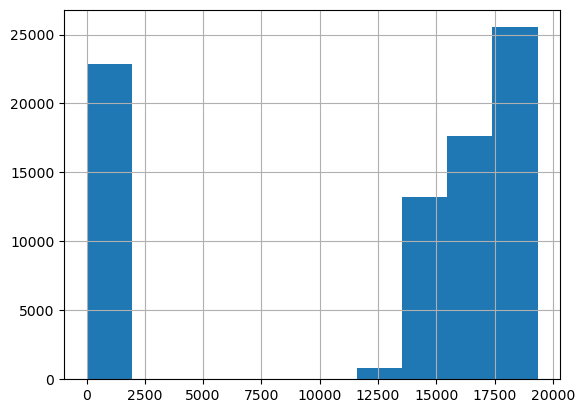

In [41]:
state.solar_power_kW_hour_18.hist()